In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [2]:
from __future__ import print_function

## Loading data, training a model

In [3]:
file1 = 'Flight-Level-False-Pos-Data_160920.csv'

df1 = pd.read_csv(file1)
df1 = df1.set_index('p14_event_record')

#df1.head()

## setting features and targets

In [4]:
#df1.columns.tolist()

In [5]:
features = ['flight_record',
 'flight_date_exact',
 'tail_number',
 'airframe',
 'fleet',
 'takeoff_airport_code',
 'landing_airport_code',
 'p14_event_type',
 'p14_severity',
 'p14_false_positive',
 'p14_start_of_event_10_seconds_seconds_from_start_of_file',
 'p14_end_of_event_10_seconds_seconds_from_start_of_file',
 'p14_data_dropouts_seconds',
 'p14_error_b_w_gmt_and_recorded_time_around_event_percent',
 'p14_estimated_nav_error_at_start_of_event_nm',
 'p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz',
 'p14_flap_handle_position_at_start_of_event',
 'p14_speed_brake_handle_position_at_start_of_event_deg',
 'p14_flap_position_at_start_of_event_deg_ted'
           ]

target = 'target'

In [6]:
X = df1[features]
y = df1[target]

## train test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
X_train.shape

(1677, 19)

In [9]:
X_test.shape

(719, 19)

## functions for processing data

In [10]:
def process_severity(df):
    """convert severity level Column into integers 

    Usage
    ------

    train = process_severity(train)
    """    
    df['p14_severity'] = df['p14_severity'].map({'Level 2': 0,
                              'Level 3': 1})
    return df

def process_event_type(df):
    """Create Dummy Columns (One Hot Encoding) from p14_event_type Column 

    Usage
    ------

    train = process_event_type(train)
    """
    df = pd.get_dummies(df, columns=['p14_event_type'], prefix='event_type')
    return df

def scale_data(df):
    """scales the data from the data set 

    Usage
    ------

    train = scale_data(train)
    """      
    scaler = StandardScaler().fit(df)
    X_Scaler = scaler.transform(df)
    df = pd.DataFrame(X_Scaler, columns = df.columns)
    return df
    
def impute_null_vales(df):
    """Handle missing values from the data set

    Usage
    ------

    holdout = impute_null_vales(holdout)
    """
    imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(df)
    X_imputed = imputer.transform(df)
    df = pd.DataFrame(X_imputed, columns = df.columns)
    return df

def drop_columns(df):
    """removes surplus columns from df

    Usage
    ------

    holdout = drop_columns(holdout)
    """    
    df = df.drop(columns=['flight_record'
                          , 'flight_date_exact'
                          , 'tail_number'
                          , 'airframe'
                          , 'fleet'
                          , 'takeoff_airport_code'
                          , 'landing_airport_code'
                          , 'p14_false_positive'])
    return df

In [11]:
def process_df(df):
    """runs multiple functions to transform the data to feed into the model

    Usage
    ------

    holdout = process_df(holdout)
    """
    df = drop_columns(df)
    df = impute_null_vales(df)
    df = process_severity(df)
    df = process_event_type(df)       
    return df

## Transform training data

In [12]:
X_train = process_df(X_train)

In [13]:
#X_train.isnull().sum()
X_train[pd.isnull(X_train).any(axis=1)] 

,p14_severity,p14_start_of_event_10_seconds_seconds_from_start_of_file,p14_end_of_event_10_seconds_seconds_from_start_of_file,p14_data_dropouts_seconds,p14_error_b_w_gmt_and_recorded_time_around_event_percent,p14_estimated_nav_error_at_start_of_event_nm,p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz,p14_flap_handle_position_at_start_of_event,p14_speed_brake_handle_position_at_start_of_event_deg,p14_flap_position_at_start_of_event_deg_ted,...,event_type_Pitch Rate Low during Rotation,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_Stick shaker,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance


In [14]:
X_train.shape

(1677, 56)

In [15]:
X_train.describe().round(2)

,p14_severity,event_type_Airborne Speed High,event_type_Airspeed Low Relative to Stall Speed,event_type_Altitude Excursion,event_type_Approach Speed High Below 50 ft AGL (Vref),event_type_Below Minimum Maneuver Speed,event_type_Climb Speed High,event_type_Climb Speed Low,event_type_Deep Touchdown,event_type_Deviation Above GlideSlope 500 to 200 ft AGL,...,event_type_Pitch Rate Low during Rotation,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_Stick shaker,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance
count,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,...,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00,1677.00
mean,0.06,0.40,0.00,0.00,0.04,0.00,0.02,0.00,0.05,0.00,...,0.04,0.08,0.00,0.01,0.00,0.00,0.00,0.01,0.03,0.00
std,0.23,0.49,0.06,0.02,0.19,0.03,0.15,0.05,0.22,0.05,...,0.19,0.27,0.06,0.08,0.04,0.07,0.05,0.11,0.16,0.07
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [16]:
X_train.head()

,p14_severity,p14_start_of_event_10_seconds_seconds_from_start_of_file,p14_end_of_event_10_seconds_seconds_from_start_of_file,p14_data_dropouts_seconds,p14_error_b_w_gmt_and_recorded_time_around_event_percent,p14_estimated_nav_error_at_start_of_event_nm,p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz,p14_flap_handle_position_at_start_of_event,p14_speed_brake_handle_position_at_start_of_event_deg,p14_flap_position_at_start_of_event_deg_ted,...,event_type_Pitch Rate Low during Rotation,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_Stick shaker,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance
0,0,8412.5,8432.5,0,-9.54e-05,0.0290217,0,30,4.20074,29.9658,...,0,0,0,0,0,0,0,0,0,0
1,0,673.5,693.5,4,0.00133514,0.026421,0,1,-0.918327,1.01467,...,0,0,0,0,0,0,0,0,0,0
2,0,1548,1568,0,-9.54e-05,0.0144008,0,5,-1.47035,5.10875,...,0,0,0,0,0,0,0,0,0,0
3,0,720.25,740.25,2,0.000978,0.0131452,0,10,-1.28627,10.0318,...,0,1,0,0,0,0,0,0,0,0
4,0,13877,13897,2,-9.54e-05,0.00473688,0,1,1.28286,1.00791,...,0,0,0,0,0,0,0,0,0,0


## Transform test data

In [17]:
X_test = process_df(X_test)

In [18]:
X_test[pd.isnull(X_test).any(axis=1)] 

,p14_severity,p14_start_of_event_10_seconds_seconds_from_start_of_file,p14_end_of_event_10_seconds_seconds_from_start_of_file,p14_data_dropouts_seconds,p14_error_b_w_gmt_and_recorded_time_around_event_percent,p14_estimated_nav_error_at_start_of_event_nm,p14_standard_deviation_of_sample_rate_of_gmt_event_interval_30_seconds_hz,p14_flap_handle_position_at_start_of_event,p14_speed_brake_handle_position_at_start_of_event_deg,p14_flap_position_at_start_of_event_deg_ted,...,event_type_Pitch Rate Low during Rotation,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance,event_type_VMO Exceedance


In [19]:
X_test.shape

(719, 51)

In [20]:
X_test.describe().round(2)

,p14_severity,event_type_Airborne Speed High,event_type_Airspeed Low Relative to Stall Speed,event_type_Approach Speed High Below 50 ft AGL (Vref),event_type_Below Minimum Maneuver Speed,event_type_Climb Speed High,event_type_Deep Touchdown,event_type_Deviation Above GlideSlope 500 to 200 ft AGL,event_type_Early Flap Retraction,event_type_FLCH mode below 1000 ft HAT,...,event_type_Pitch Rate Low during Rotation,event_type_Rotation Speed High,event_type_Rotation Speed Low,event_type_Short Runway Distance Remaining,event_type_Short touchdown,event_type_Speed Brakes Used During Final Approach,event_type_TCAS Resolution Advisory,event_type_Thrust reversers delayed during landing,event_type_VFE (Flap Airspeed Limit) Exceedance,event_type_VMO Exceedance
count,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00,...,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00,719.00
mean,0.06,0.40,0.00,0.02,0.00,0.02,0.07,0.00,0.00,0.00,...,0.03,0.08,0.00,0.01,0.00,0.00,0.02,0.02,0.01,0.00
std,0.23,0.49,0.05,0.14,0.05,0.15,0.25,0.05,0.04,0.04,...,0.17,0.26,0.05,0.07,0.06,0.06,0.13,0.14,0.09,0.04
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Align the number of features in test set based on train dataset

In [21]:
def align_features(train_df, new_df):
    """ Align the number of features based on train dataset
    
    Usage
    ------

    X_test = align_features(X_test)
    
    """
    train_df, new_df = train_df.align(new_df, join='left',fill_value=0, axis=1)
    print("train_df shape: {}".format(train_df.shape))
    print("new_df shape: {}".format(new_df.shape))
    return new_df

In [22]:
X_test = align_features(X_train, X_test)

train_df shape: (1677, 56)
new_df shape: (719, 56)


In [23]:
#X_test.columns.tolist()

In [24]:
#X_train.columns.tolist()

## Resampling

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_sample(X_train, y_train)

In [26]:
X_sm.shape

(2966, 56)

In [27]:
y_sm.shape

(2966,)

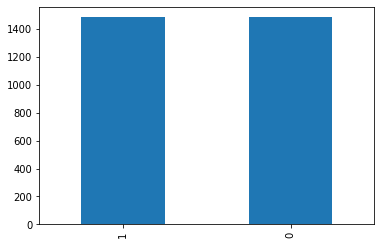

In [28]:
y_sm.value_counts().plot.bar()

## modelling

In [29]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=800
                             , min_samples_split=3
                             , min_samples_leaf=1
                             , max_features='sqrt'
                             , max_depth=90
                             , bootstrap='False')

In [30]:
clf.fit(X_sm, y_sm)

RandomForestClassifier(bootstrap='False', max_depth=90, max_features='sqrt',
                       min_samples_split=3, n_estimators=800)

In [31]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': 'False',
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 90,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


## Evaluation

In [32]:
#from sklearn.metrics import accuracy_score
#accuracy_score(y_test, clf.predict(X_test))

In [33]:
actual = y_test

prob_1 = clf.predict_proba(X_test)[:,1]

evaluate = pd.DataFrame({"actual": actual
                        , "prob_1": prob_1
                        })
threshold = 0.5

evaluate["predictions"] = (evaluate["prob_1"] > threshold) *1

print((evaluate["actual"]==evaluate["predictions"]).mean())
#evaluate

0.9707927677329624


In [34]:
#incorrect predictions
errors = evaluate[evaluate['actual']!=evaluate['predictions']]
errors

,actual,prob_1,predictions
p14_event_record,,,
40599479,0,0.749812,1
40812001,1,0.283588,0
40546981,1,0.198417,0
40621658,0,0.910958,1
40642097,0,0.737313,1
40700521,1,0.409104,0
40601120,0,0.573333,1
40530944,0,0.501354,1
40787013,0,0.682500,1


In [35]:
#errors.to_csv('evaluation.csv', index = True, header=True)

### probability/ distribution plot

[]

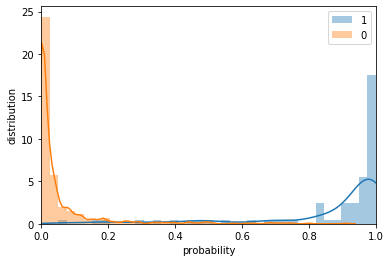

In [36]:
#import seaborn as sns
#import matplotlib.pyplot as plt

x = evaluate[evaluate['actual']==1].prob_1
y = evaluate[evaluate['actual']==0].prob_1

bins = np.linspace(0,1,40)

sns.distplot(x, bins=bins, label='1')
sns.distplot(y, bins=bins, label='0')
plt.xlim(0,1)
plt.xlabel('probability')
plt.ylabel('distribution')
plt.legend()
plt.plot()

### Classification report

In [37]:
from sklearn.metrics import classification_report

# Predict the labels of the test set
y_pred = clf.predict(X_test)

# Compute metrics
print(classification_report(y_test, y_pred))
#print("Accuracy: {}".format(cv.score(X_test, y_test)))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       641
           1       0.84      0.90      0.87        78

    accuracy                           0.97       719
   macro avg       0.92      0.94      0.93       719
weighted avg       0.97      0.97      0.97       719



**interpretaion**
- Recall – What percent of the positive cases did you catch? 
- Precision – What percent of your predictions were correct?
- F1 score – What percent of positive predictions were correct? 
    - the harmonic mean between precision & recall
- The support is the number of occurence of the given class in your dataset

### confusion matrix

cm = pd.crosstab(
    evaluate["actual"]
    , evaluate["predictions"]
    , rownames = ["Actual"]
    , colnames = ["Prediction"]
    , margins = True
)
cm

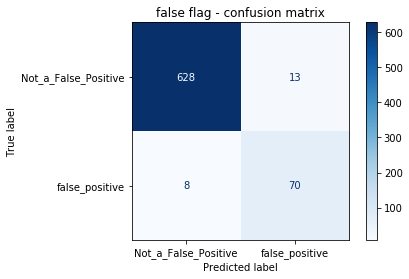

In [38]:
from sklearn.metrics import plot_confusion_matrix

disp = plot_confusion_matrix(clf, X_test,y_test, cmap=plt.cm.Blues,display_labels=dict(Not_a_False_Positive=0,false_positive=1))
disp.ax_.set_title("false flag - confusion matrix")
plt.show()

### ROC curve

In [39]:
# Import necessary modules
from sklearn.metrics import auc, roc_curve

false_positive_rate, true_positive_rate, thresholds = roc_curve(evaluate["actual"] , evaluate["predictions"])
roc_auc = auc(false_positive_rate, true_positive_rate)
print (roc_auc)

0.938577543101724


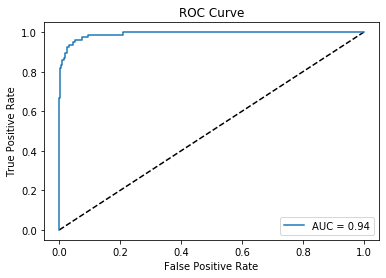

In [40]:
# Compute predicted probabilities: y_pred_prob
y_pred_prob = clf.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## feature importance

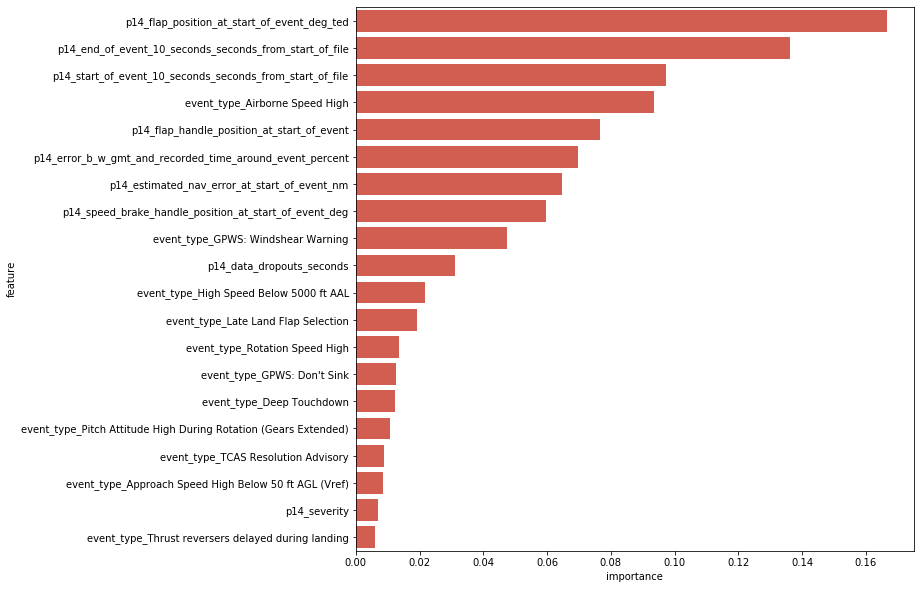

,feature,importance,cum_sum
0,p14_flap_position_at_start_of_event_deg_ted,0.166738,0.166738
1,p14_end_of_event_10_seconds_seconds_from_start...,0.136239,0.302977
2,p14_start_of_event_10_seconds_seconds_from_sta...,0.097375,0.400352
3,event_type_Airborne Speed High,0.093536,0.493888
4,p14_flap_handle_position_at_start_of_event,0.076599,0.570487
5,p14_error_b_w_gmt_and_recorded_time_around_eve...,0.069813,0.640299
6,p14_estimated_nav_error_at_start_of_event_nm,0.064839,0.705138
7,p14_speed_brake_handle_position_at_start_of_ev...,0.059756,0.764894
8,event_type_GPWS: Windshear Warning,0.047489,0.812383
9,p14_data_dropouts_seconds,0.031046,0.843429


Original number of columns: 19


In [42]:
n_records = 20

importances = pd.DataFrame({
    "feature": X_train.columns.tolist(),
    "importance": clf.feature_importances_
})
importances = importances.sort_values("importance", ascending=False).reset_index(drop=True)
importances["cum_sum"] = np.cumsum(importances.importance)

fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(importances[:n_records].importance, importances[:n_records].feature, color='#E74C3C')

plt.show()

display(importances[:n_records])
print(f"Original number of columns: {len(features)}")

## Create the explainer

In [43]:
import lime
import lime.lime_tabular

In [44]:
def ref_number(event_num):
    for i, x in enumerate(y_test.index):
        if event_num == x:
            #print (i)
            return i

In [45]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train
                                                   , feature_names= X_train.columns.tolist()
                                                   , class_names= target
                                                   , mode='regression'
                                                   , discretize_continuous=False
                                                   )

In [46]:
errors

,actual,prob_1,predictions
p14_event_record,,,
40599479,0,0.749812,1
40812001,1,0.283588,0
40546981,1,0.198417,0
40621658,0,0.910958,1
40642097,0,0.737313,1
40700521,1,0.409104,0
40601120,0,0.573333,1
40530944,0,0.501354,1
40787013,0,0.682500,1


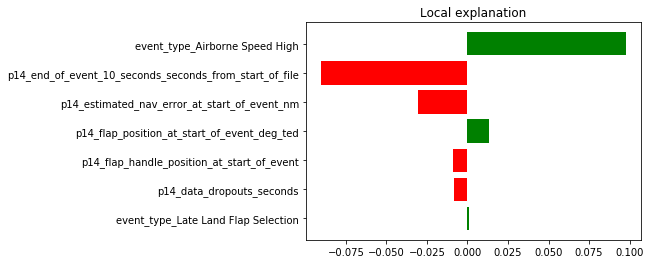

,Feature,Value
0,event_type_Airborne Speed High,0.097557
1,p14_end_of_event_10_seconds_seconds_from_start...,-0.090156
2,p14_estimated_nav_error_at_start_of_event_nm,-0.030630
3,p14_flap_position_at_start_of_event_deg_ted,0.013403
4,p14_flap_handle_position_at_start_of_event,-0.008859
5,p14_data_dropouts_seconds,-0.008468
6,event_type_Late Land Flap Selection,0.001236


In [48]:
i = ref_number(40621658)
exp = explainer.explain_instance(np.array(X_test)[i], clf.predict_proba, num_features=7)

#exp.show_in_notebook(show_table=True, show_all=False)
exp.as_pyplot_figure()
plt.show()

table = pd.DataFrame(exp.as_list(label=1), columns=['Feature', 'Value'])
table